In [1]:
import pickle
import numpy as np
import numba
import umap
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

/home/dx63/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#import beta coordinates with PCET distance and euler angles
with open('output/turnover_beta_coords.pkl', 'rb') as f:
    turnover_beta_coords = pickle.load(f)
#import beta coordinates with COM distance and quat angles
with open('output/turnover_beta_coords_quat.pkl', 'rb') as f:
    turnover_beta_coords_quat = pickle.load(f)

In [3]:
# We define a custom metric for densMAP calculation, where the distance between two beta coords is 
# the sum of the L2 norm of translation and the difference in angle between the quaternions
@numba.njit()
def euc_quat_sum(coord1, coord2):
    def hamilton_prod(quat1, quat2):
        x1, y1, z1, w1 = quat1
        x2, y2, z2, w2 = quat2
        return np.array([w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2,
                         w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2,
                         w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2,
                         w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2], dtype=np.float64)
    
    def quat_inv(quat):
        x, y, z, w = quat
        return np.array([-x, -y, -z, w], dtype=np.float64)
    
    def quat_to_ang(quat):
        x, y, z, w = quat
        return np.abs(2 * np.arctan2(np.sqrt(x**2 + y**2 + z**2), w) / np.pi * 180)
    
    xyz1 = coord1[:3]
    quat1 = coord1[3:]
    xyz2 = coord2[:3]
    quat2 = coord2[3:]
    euc_d = np.linalg.norm(xyz1 - xyz2)
    quat_d = quat_to_ang(hamilton_prod(quat_inv(quat1), quat2))
    return euc_d + quat_d

In [4]:
# Here we calculate densMAP for turnover condition only, while in paper we combine beta coords from all condition to perform a unified embedding.
reducer = umap.UMAP(random_state=0, metric=euc_quat_sum, n_neighbors=50, densmap=True)
embedding = reducer.fit_transform(turnover_beta_coords_quat)

/home/dx63/.local/lib/python3.9/site-packages/umap/umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


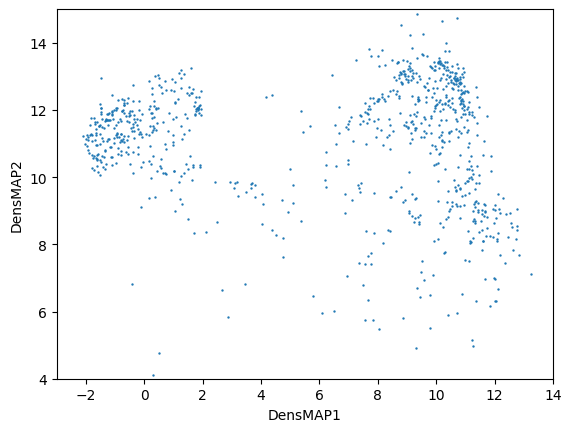

In [5]:
sc = plt.scatter(embedding[:, 0], embedding[:, 1], s=0.5)
plt.xlabel('DensMAP1')
plt.ylabel('DensMAP2')
plt.xlim([-3, 14])
plt.ylim([4, 15])
plt.show()

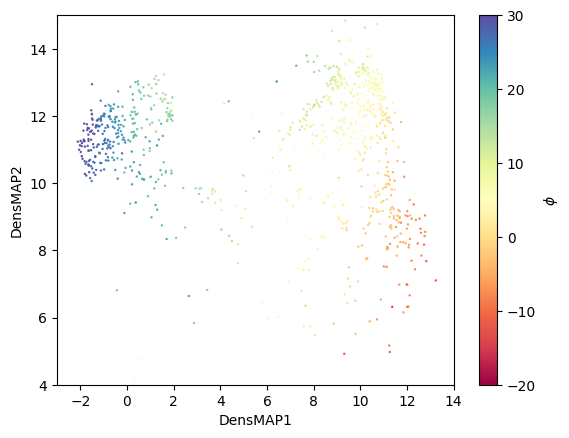

In [6]:
# embedding colored by Euler angle phi
sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=turnover_beta_coords[:, 5], cmap='Spectral', s=0.5, vmin=-20, vmax=30)
cbar = plt.colorbar(sc)
plt.xlabel('DensMAP1')
plt.ylabel('DensMAP2')
plt.xlim([-3, 14])
plt.ylim([4, 15])
cbar.ax.set_ylabel('$\phi$')
plt.show()

In [7]:
# load particle count for each volume
with open('output/turnover_vol_ptcl_count.pkl','rb') as f:
    turnover_vol_ptcl_count = pickle.load(f)

In [8]:
# estimate a density function using a gaussian kernel
grid1 = np.linspace(-3, 14, 200)
grid2 = np.linspace(4, 15, 200)
xx, yy = np.meshgrid(grid1, grid2)
positions = np.vstack([xx.ravel(), yy.ravel()])

gkde_full = gaussian_kde(embedding[:,:].T, weights=turnover_vol_ptcl_count)
gkde_full_at_grid_points = np.reshape(gkde_full(positions).T, xx.shape)

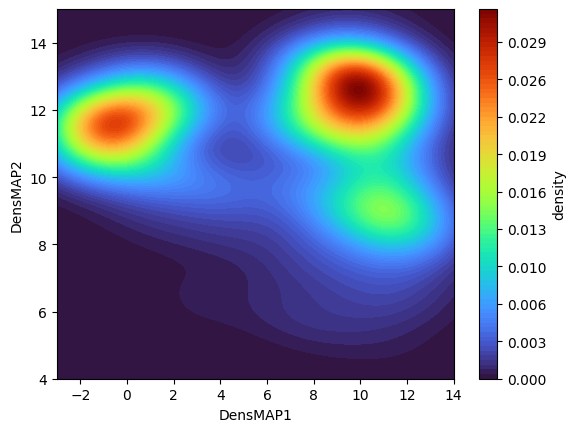

In [9]:
# conformational landscape
sc = plt.contourf(xx, yy, gkde_full_at_grid_points, levels = 100, cmap='turbo')
cbar = plt.colorbar(sc, format=lambda x, _: f"{x:.3f}")
plt.xlabel('DensMAP1')
plt.ylabel('DensMAP2')
cbar.ax.set_ylabel('density')
plt.show()

In [10]:
with open('output/turnover_TrxA_A_occu.pkl','rb') as f:
    turnover_TrxA_A = pickle.load(f)
with open('output/turnover_TrxA_C_occu.pkl','rb') as f:
    turnover_TrxA_C = pickle.load(f)

Text(0, 0.5, 'chain C TrxA occupancy')

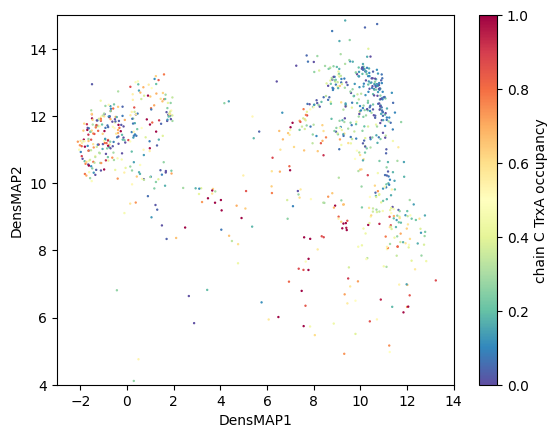

In [11]:
# embedding colored by chain C TrxA occupancy (alpha prime)
sc = plt.scatter(embedding[:, 0], embedding[:, 1], c=turnover_TrxA_C, cmap='Spectral_r', s=0.5, vmin=0.0, vmax=1.0)
cbar = plt.colorbar(sc)
plt.xlabel('DensMAP1')
plt.ylabel('DensMAP2')
plt.xlim([-3, 14])
plt.ylim([4, 15])
cbar.ax.set_ylabel('chain C TrxA occupancy')

Text(0, 0.5, 'chain A TrxA occupancy')

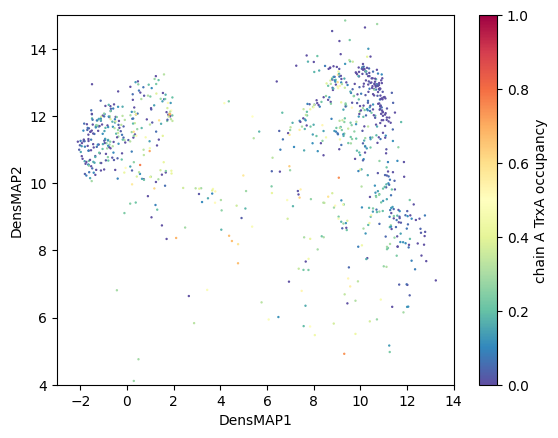

In [12]:
# embedding colored by chain A TrxA occupancy (alpha)
sc = plt.scatter(embedding[:, 0],embedding[:, 1],c=turnover_TrxA_A,cmap='Spectral_r', s=0.5, vmin=0.0, vmax=1.0)
cbar = plt.colorbar(sc)
plt.xlabel('DensMAP1')
plt.ylabel('DensMAP2')
plt.xlim([-3, 14])
plt.ylim([4, 15])
cbar.ax.set_ylabel('chain A TrxA occupancy')